In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v6.0.1_vicious_cycle/ciff_sam/2022_02_23_17_26_53/count_data/'
output_dir_533 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v5.3.3_sam_k_sensitivity/ciff_sam/2022_02_08_09_51_56/count_data/'

In [68]:
def calculate_wasting_values(output_dir, ages, strata_cols, measure, metric, 
                             relative_scenario):
    if measure=='prevalence':
        data6 = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        data6['model'] = '6'
        data5 = pd.read_csv(output_dir_533 + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        data5['model'] = '5'
        data = pd.concat([data6,data5.loc[data5.sam_k=='alternative']])
        wasted = data.loc[data.cause.str.contains('acute_malnutrition')].drop(columns=['sam_k','diarrhea'])
        wasted['cause'] = 'wasted'
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
    elif measure=='incidence':
        data6 = (pd.read_csv(output_dir + 'wasting_transition_count.csv')
                .drop(columns=['Unnamed: 0']).rename(columns={'measure':'cause'}))
        data5 = (pd.read_csv(output_dir_533 + 'wasting_transition_count.csv')
                .drop(columns=['Unnamed: 0']).rename(columns={'measure':'cause'}))
        data6['model'] = '6'
        data5['model'] = '5'
        data = pd.concat([data6,data5.loc[data5.sam_k=='alternative']]).drop(columns=['sam_k','diarrhea'])
        wasted = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'])]
        wasted['cause'] = 'wasted'
        total_mam = data.loc[data.cause.isin(['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
                                             'severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count'])]
        total_mam['cause'] = 'total_mam'
        wasted = pd.concat([wasted,total_mam])
        wasted = (wasted.groupby([c for c in wasted.columns if c != 'value']).sum())
        data = pd.concat([data,wasted.reset_index()],ignore_index=True)
        
        pt6 = pd.read_csv(output_dir + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        pt6['model'] = '6'
        pt5 = pd.read_csv(output_dir_533 + 'wasting_state_person_time.csv').drop(columns=['Unnamed: 0'])
        pt5['model'] = '5'
        pt = pd.concat([pt5.loc[pt5.sam_k=='alternative'],pt6]).drop(columns=['sam_k','diarrhea'])
        
    groupby_cols = ['input_draw','scenario','cause']
    data = data.loc[data.age.isin(ages)]    
    data = data.groupby(['input_draw','scenario'] + strata_cols + ['cause']).sum()
    if measure=='prevalence':
        data = data / data.groupby(['input_draw','scenario'] + strata_cols).sum() * 100
    else:
        pt = pt.loc[pt.age.isin(ages)].groupby(['input_draw','scenario'] + strata_cols).sum()
        data = data / pt * 100_000     
    if metric=='value':
        data = (data.groupby(['scenario','cause'] + strata_cols)
                    .describe(percentiles=[0.025,0.975]))
    else:
        data_baseline = (data.reset_index().loc[data.reset_index().scenario==relative_scenario]
                   .set_index(['input_draw','cause'] + strata_cols)
                   .drop(columns='scenario'))
        if metric=='percent_reduction':
            data = ((data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario']))
                    / data_baseline) * 100
        elif metric=='absolute_reduction':
            data = data_baseline - data.reset_index().set_index(['input_draw','cause'] + strata_cols + ['scenario'])
            
        data = (data.reset_index().groupby(['scenario','cause'] + strata_cols)
                .describe(percentiles=[0.025,0.975])).drop(columns='input_draw')
    return data[['value']].reset_index()

In [42]:
six_to_59_ages = ['6-11_months',
       '12_to_23_months', '2_to_4']
ages = ['6-11_months',
       '12_to_23_months', '2_to_4']

In [61]:
d = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year'], 
                                        'incidence', 
                                        'value', 
                                        'baseline')
d

<ipython-input-60-b73cab44a4bb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-60-b73cab44a4bb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'


scenario                                              cause  \
                                                                            
0             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
1             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
2             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
3             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
4             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
..                 ...                                                ...   
355  wasting_treatment                                             wasted   
356  wasting_treatment                                             wasted   
357  wasting_treatment                                             wasted   
358  wasting_treatment                                             wasted   
359  wasting_treatment                                             wasted   

    model  year value                                                         \
                count          mean          std           min          2.5%   
0       5  2022  12.0  21959.552675  1440.137543  19936.818020  20011.943239   
1       5  2023  12.0  21918.844780  1485.534314  19909.048621  19972.595514   
2       5  2024  12.0  21868.176699  1459.888836  19811.114398  19926.802322   
3       5  2025  12.0  21855.550792  1459.605245  19794.105481  19881.979048   
4       5  2026  12.0  21858.904634  1421.566520  19933.331688  20000.636330   
..    ...   ...   ...           ...          ...           ...           ...   
355     6  2022  12.0  50136.689941  1314.213408  47741.980095  47988.377656   
356     6  2023  12.0  49993.115674  1314.733137  47050.228260  47597.242261   
357     6  2024  12.0  50042.348411  1318.107400  47256.584353  47671.000478   
358     6  2025  12.0  50110.524726  1470.445857  47472.183296  47792.084108   
359     6  2026  12.0  50250.688908  1509.996312  47109.888445  47464.975689   

                                               
              50%         97.5%           max  
0    21799.652140  24047.272753  24144.894199  
1    21795.731618  24094.355259  24205.934217  
2    21719.576774  23836.241731  23844.766259  
3    21791.853043  23922.002264  23938.327407  
4    21672.349802  23841.207148  23842.164151  
..            ...           ...           ...  
355  50268.096197  51844.714819  51877.954031  
356  50135.939372  51634.102339  51649.205538  
357  50211.353288  51531.927712  51539.720271  
358  50107.066440  52216.630832  52217.322828  
359  50499.200301  52282.795592  52296.202117  

[360 rows x 12 columns]

In [44]:
d.cause.unique()

array(['mild_child_wasting', 'moderate_acute_malnutrition',
       'severe_acute_malnutrition', 'susceptible_to_child_wasting',
       'wasted'], dtype=object)

## Finding 1: cross sectional prevalence

Text(1.5, 2.7, 'Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children 24 to 59 months\n(with 95% uncertainty intervals)')

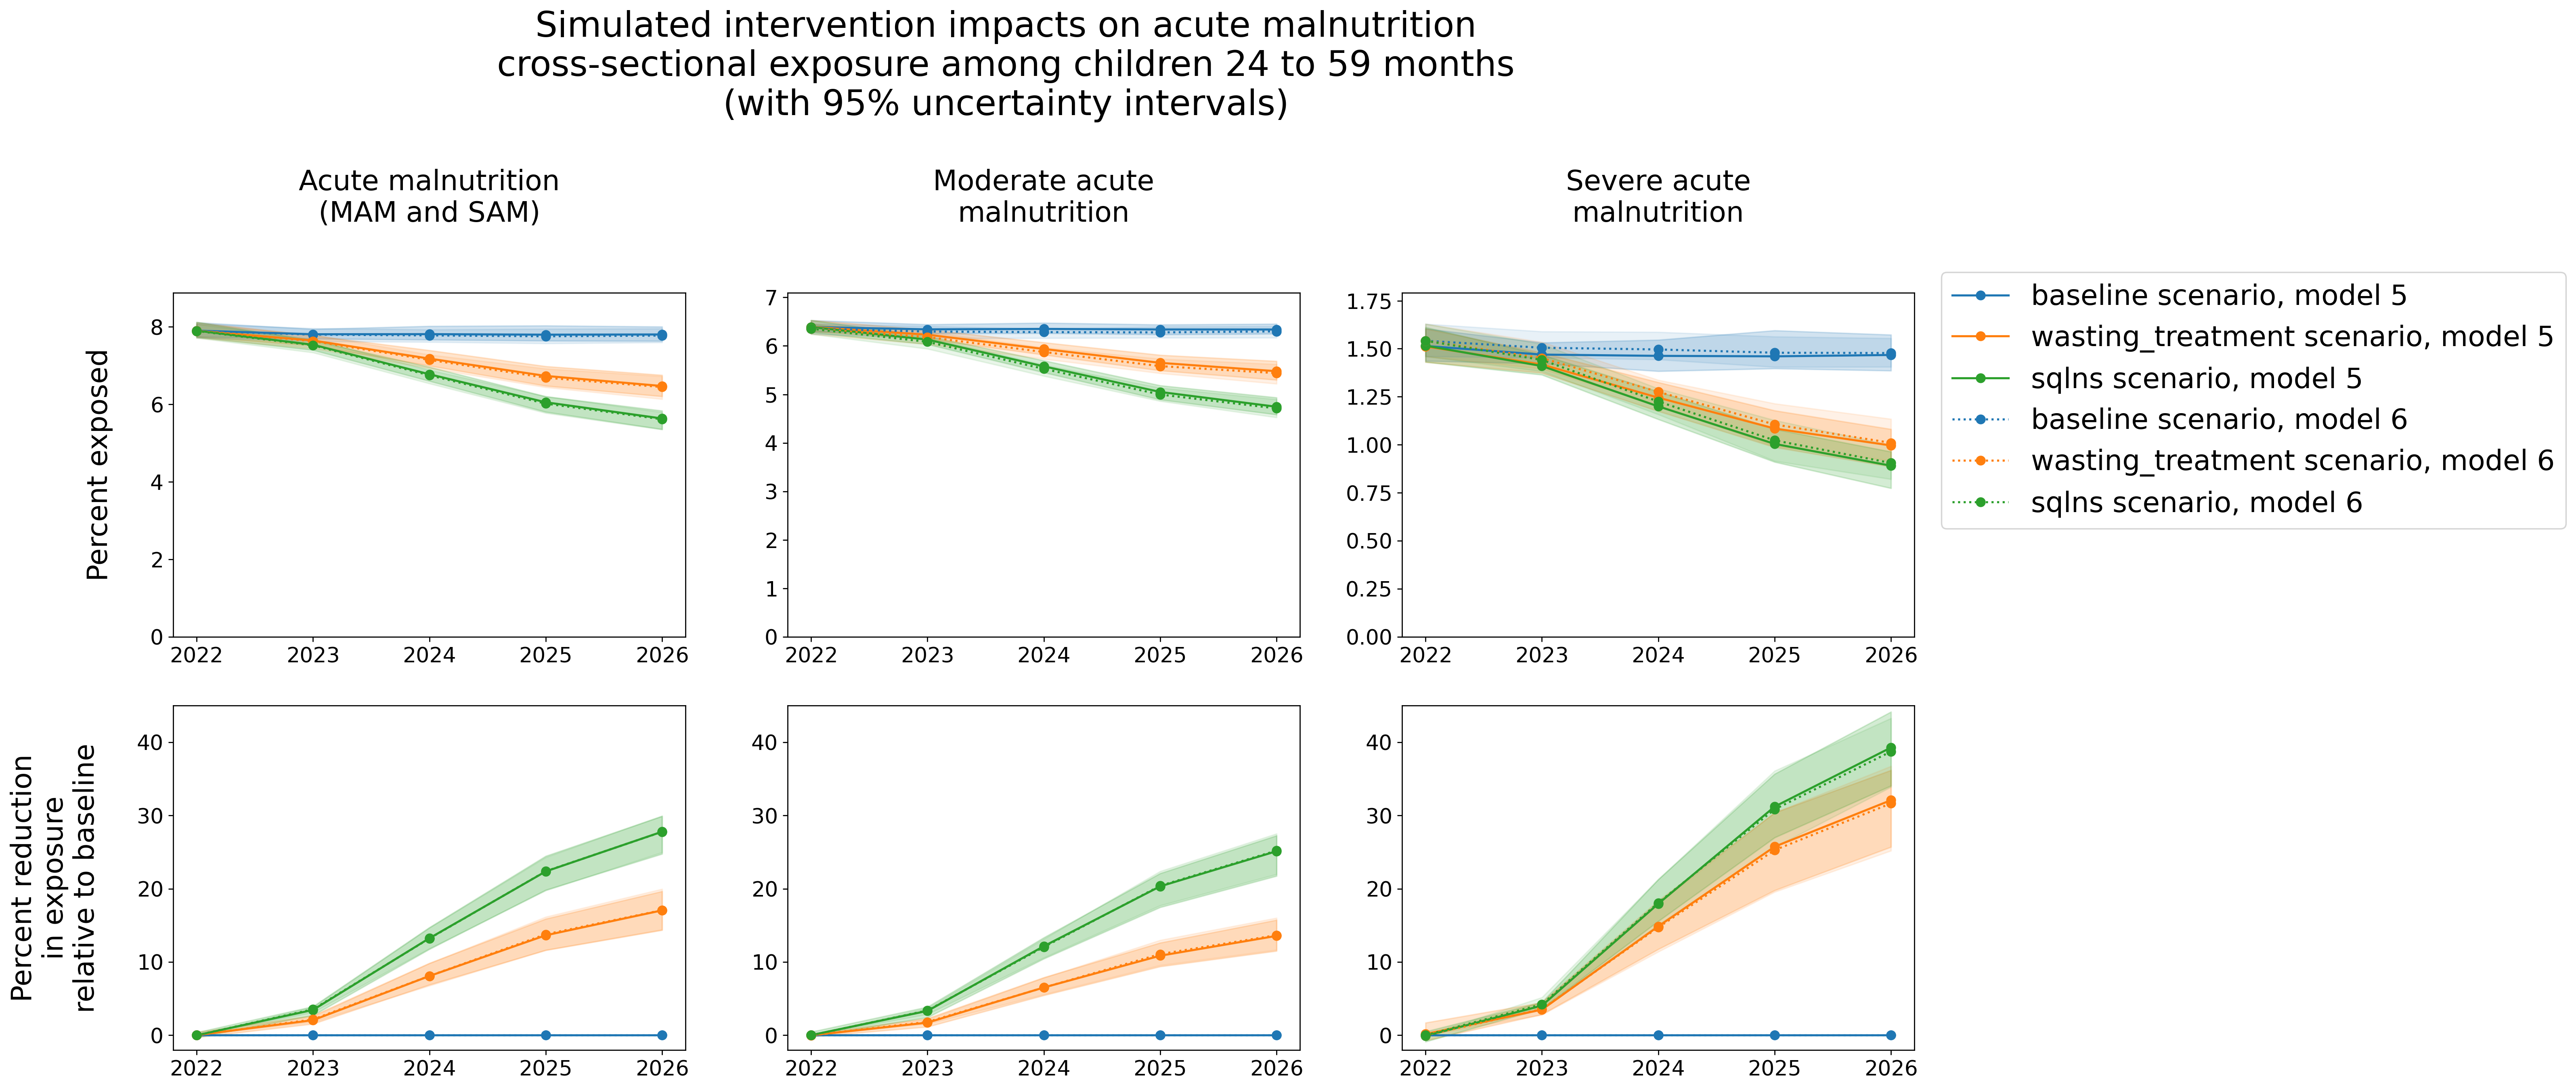

In [53]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year'], 
                                        'prevalence', 
                                        metric, 
                                        'baseline')
    for model in ['5','6']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.model==model)]
            pos = axs[metrics.index(metric),causes.index(cause)]   
            for i in ['baseline','wasting_treatment','sqlns']:
                p_sub = p.loc[p.scenario==i]
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if model == '5':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, model {model}',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
                pos.grid()
            pos.set_xticks(p_sub.year.unique())
            pos.set_xticklabels(p_sub.year.unique(),fontsize=15)
            pos.tick_params(axis='y', labelsize=15)
            if metrics.index(metric)==0:
                pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent exposed\n',size=20)
                    #pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'], 
                    #       fontsize=15)
            if metric=='percent_reduction':
                pos.set_ylim(-2,45)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent reduction\nin exposure\nrelative to baseline\n',size=20)
            pos.grid()
plt.subplots_adjust(right=len(causes), top=len(metrics))
plt.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'], 
    bbox_to_anchor=[2.3,2.3], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\ncross-sectional exposure among children 24 to 59 months\n(with 95% uncertainty intervals)',
             y=2.7,x=1.5,size=25)

In [63]:
data = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year'], 
                                        'incidence', 
                                        metric, 
                                  'baseline')
data

<ipython-input-60-b73cab44a4bb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-60-b73cab44a4bb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'


scenario                                              cause  \
                                                                            
0             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
1             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
2             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
3             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
4             baseline  mild_child_wasting_to_moderate_acute_malnutrit...   
..                 ...                                                ...   
355  wasting_treatment                                             wasted   
356  wasting_treatment                                             wasted   
357  wasting_treatment                                             wasted   
358  wasting_treatment                                             wasted   
359  wasting_treatment                                             wasted   

    model  year value                                                    \
                count      mean       std       min      2.5%       50%   
0       5  2022  12.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1       5  2023  12.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2       5  2024  12.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3       5  2025  12.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4       5  2026  12.0  0.000000  0.000000  0.000000  0.000000  0.000000   
..    ...   ...   ...       ...       ...       ...       ...       ...   
355     6  2022  12.0  0.000000  0.000000  0.000000  0.000000  0.000000   
356     6  2023  12.0 -0.219671  0.028605 -0.268199 -0.265512 -0.218443   
357     6  2024  12.0 -0.514173  0.081837 -0.676141 -0.668608 -0.496600   
358     6  2025  12.0 -0.703316  0.122343 -0.840314 -0.836276 -0.737529   
359     6  2026  12.0 -0.803275  0.156917 -1.065976 -1.064495 -0.763266   

                         
        97.5%       max  
0    0.000000  0.000000  
1    0.000000  0.000000  
2    0.000000  0.000000  
3    0.000000  0.000000  
4    0.000000  0.000000  
..        ...       ...  
355  0.000000  0.000000  
356 -0.177278 -0.172002  
357 -0.401576 -0.378411  
358 -0.482655 -0.453940  
359 -0.604533 -0.598791  

[360 rows x 12 columns]

In [65]:
data.loc[data.model=='6'].loc[data.scenario=='baseline']

scenario                                              cause model  year  \
                                                                              
5   baseline  mild_child_wasting_to_moderate_acute_malnutrit...     6  2022   
6   baseline  mild_child_wasting_to_moderate_acute_malnutrit...     6  2023   
7   baseline  mild_child_wasting_to_moderate_acute_malnutrit...     6  2024   
8   baseline  mild_child_wasting_to_moderate_acute_malnutrit...     6  2025   
9   baseline  mild_child_wasting_to_moderate_acute_malnutrit...     6  2026   
15  baseline  mild_child_wasting_to_susceptible_to_child_was...     6  2022   
16  baseline  mild_child_wasting_to_susceptible_to_child_was...     6  2023   
17  baseline  mild_child_wasting_to_susceptible_to_child_was...     6  2024   
18  baseline  mild_child_wasting_to_susceptible_to_child_was...     6  2025   
19  baseline  mild_child_wasting_to_susceptible_to_child_was...     6  2026   
25  baseline  moderate_acute_malnutrition_to_mild_child_wast...     6  2022   
26  baseline  moderate_acute_malnutrition_to_mild_child_wast...     6  2023   
27  baseline  moderate_acute_malnutrition_to_mild_child_wast...     6  2024   
28  baseline  moderate_acute_malnutrition_to_mild_child_wast...     6  2025   
29  baseline  moderate_acute_malnutrition_to_mild_child_wast...     6  2026   
35  baseline  moderate_acute_malnutrition_to_severe_acute_ma...     6  2022   
36  baseline  moderate_acute_malnutrition_to_severe_acute_ma...     6  2023   
37  baseline  moderate_acute_malnutrition_to_severe_acute_ma...     6  2024   
38  baseline  moderate_acute_malnutrition_to_severe_acute_ma...     6  2025   
39  baseline  moderate_acute_malnutrition_to_severe_acute_ma...     6  2026   
45  baseline  severe_acute_malnutrition_to_mild_child_wastin...     6  2022   
46  baseline  severe_acute_malnutrition_to_mild_child_wastin...     6  2023   
47  baseline  severe_acute_malnutrition_to_mild_child_wastin...     6  2024   
48  baseline  severe_acute_malnutrition_to_mild_child_wastin...     6  2025   
49  baseline  severe_acute_malnutrition_to_mild_child_wastin...     6  2026   
55  baseline  severe_acute_malnutrition_to_moderate_acute_ma...     6  2022   
56  baseline  severe_acute_malnutrition_to_moderate_acute_ma...     6  2023   
57  baseline  severe_acute_malnutrition_to_moderate_acute_ma...     6  2024   
58  baseline  severe_acute_malnutrition_to_moderate_acute_ma...     6  2025   
59  baseline  severe_acute_malnutrition_to_moderate_acute_ma...     6  2026   
65  baseline  susceptible_to_child_wasting_to_mild_child_was...     6  2022   
66  baseline  susceptible_to_child_wasting_to_mild_child_was...     6  2023   
67  baseline  susceptible_to_child_wasting_to_mild_child_was...     6  2024   
68  baseline  susceptible_to_child_wasting_to_mild_child_was...     6  2025   
69  baseline  susceptible_to_child_wasting_to_mild_child_was...     6  2026   
75  baseline                                          total_mam     6  2022   
76  baseline                                          total_mam     6  2023   
77  baseline                                          total_mam     6  2024   
78  baseline                                          total_mam     6  2025   
79  baseline                                          total_mam     6  2026   
85  baseline                                             wasted     6  2022   
86  baseline                                             wasted     6  2023   
87  baseline                                             wasted     6  2024   
88  baseline                                             wasted     6  2025   
89  baseline                                             wasted     6  2026   

   value                                      
   count mean  std  min 2.5%  50% 97.5%  max  
5   12.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6   12.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
7   12.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
8   12.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
9   12.0

# Finding 2: incidence

<ipython-input-68-2e3841687b99>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasted['cause'] = 'wasted'
<ipython-input-68-2e3841687b99>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_mam['cause'] = 'total_mam'
<ipython-input-68-2e3841687b99>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Text(1, 3.5, 'Simulated intervention impacts on acute malnutrition\nincidence rates among children six to 59 months\n(with 95% uncertainty intervals)')

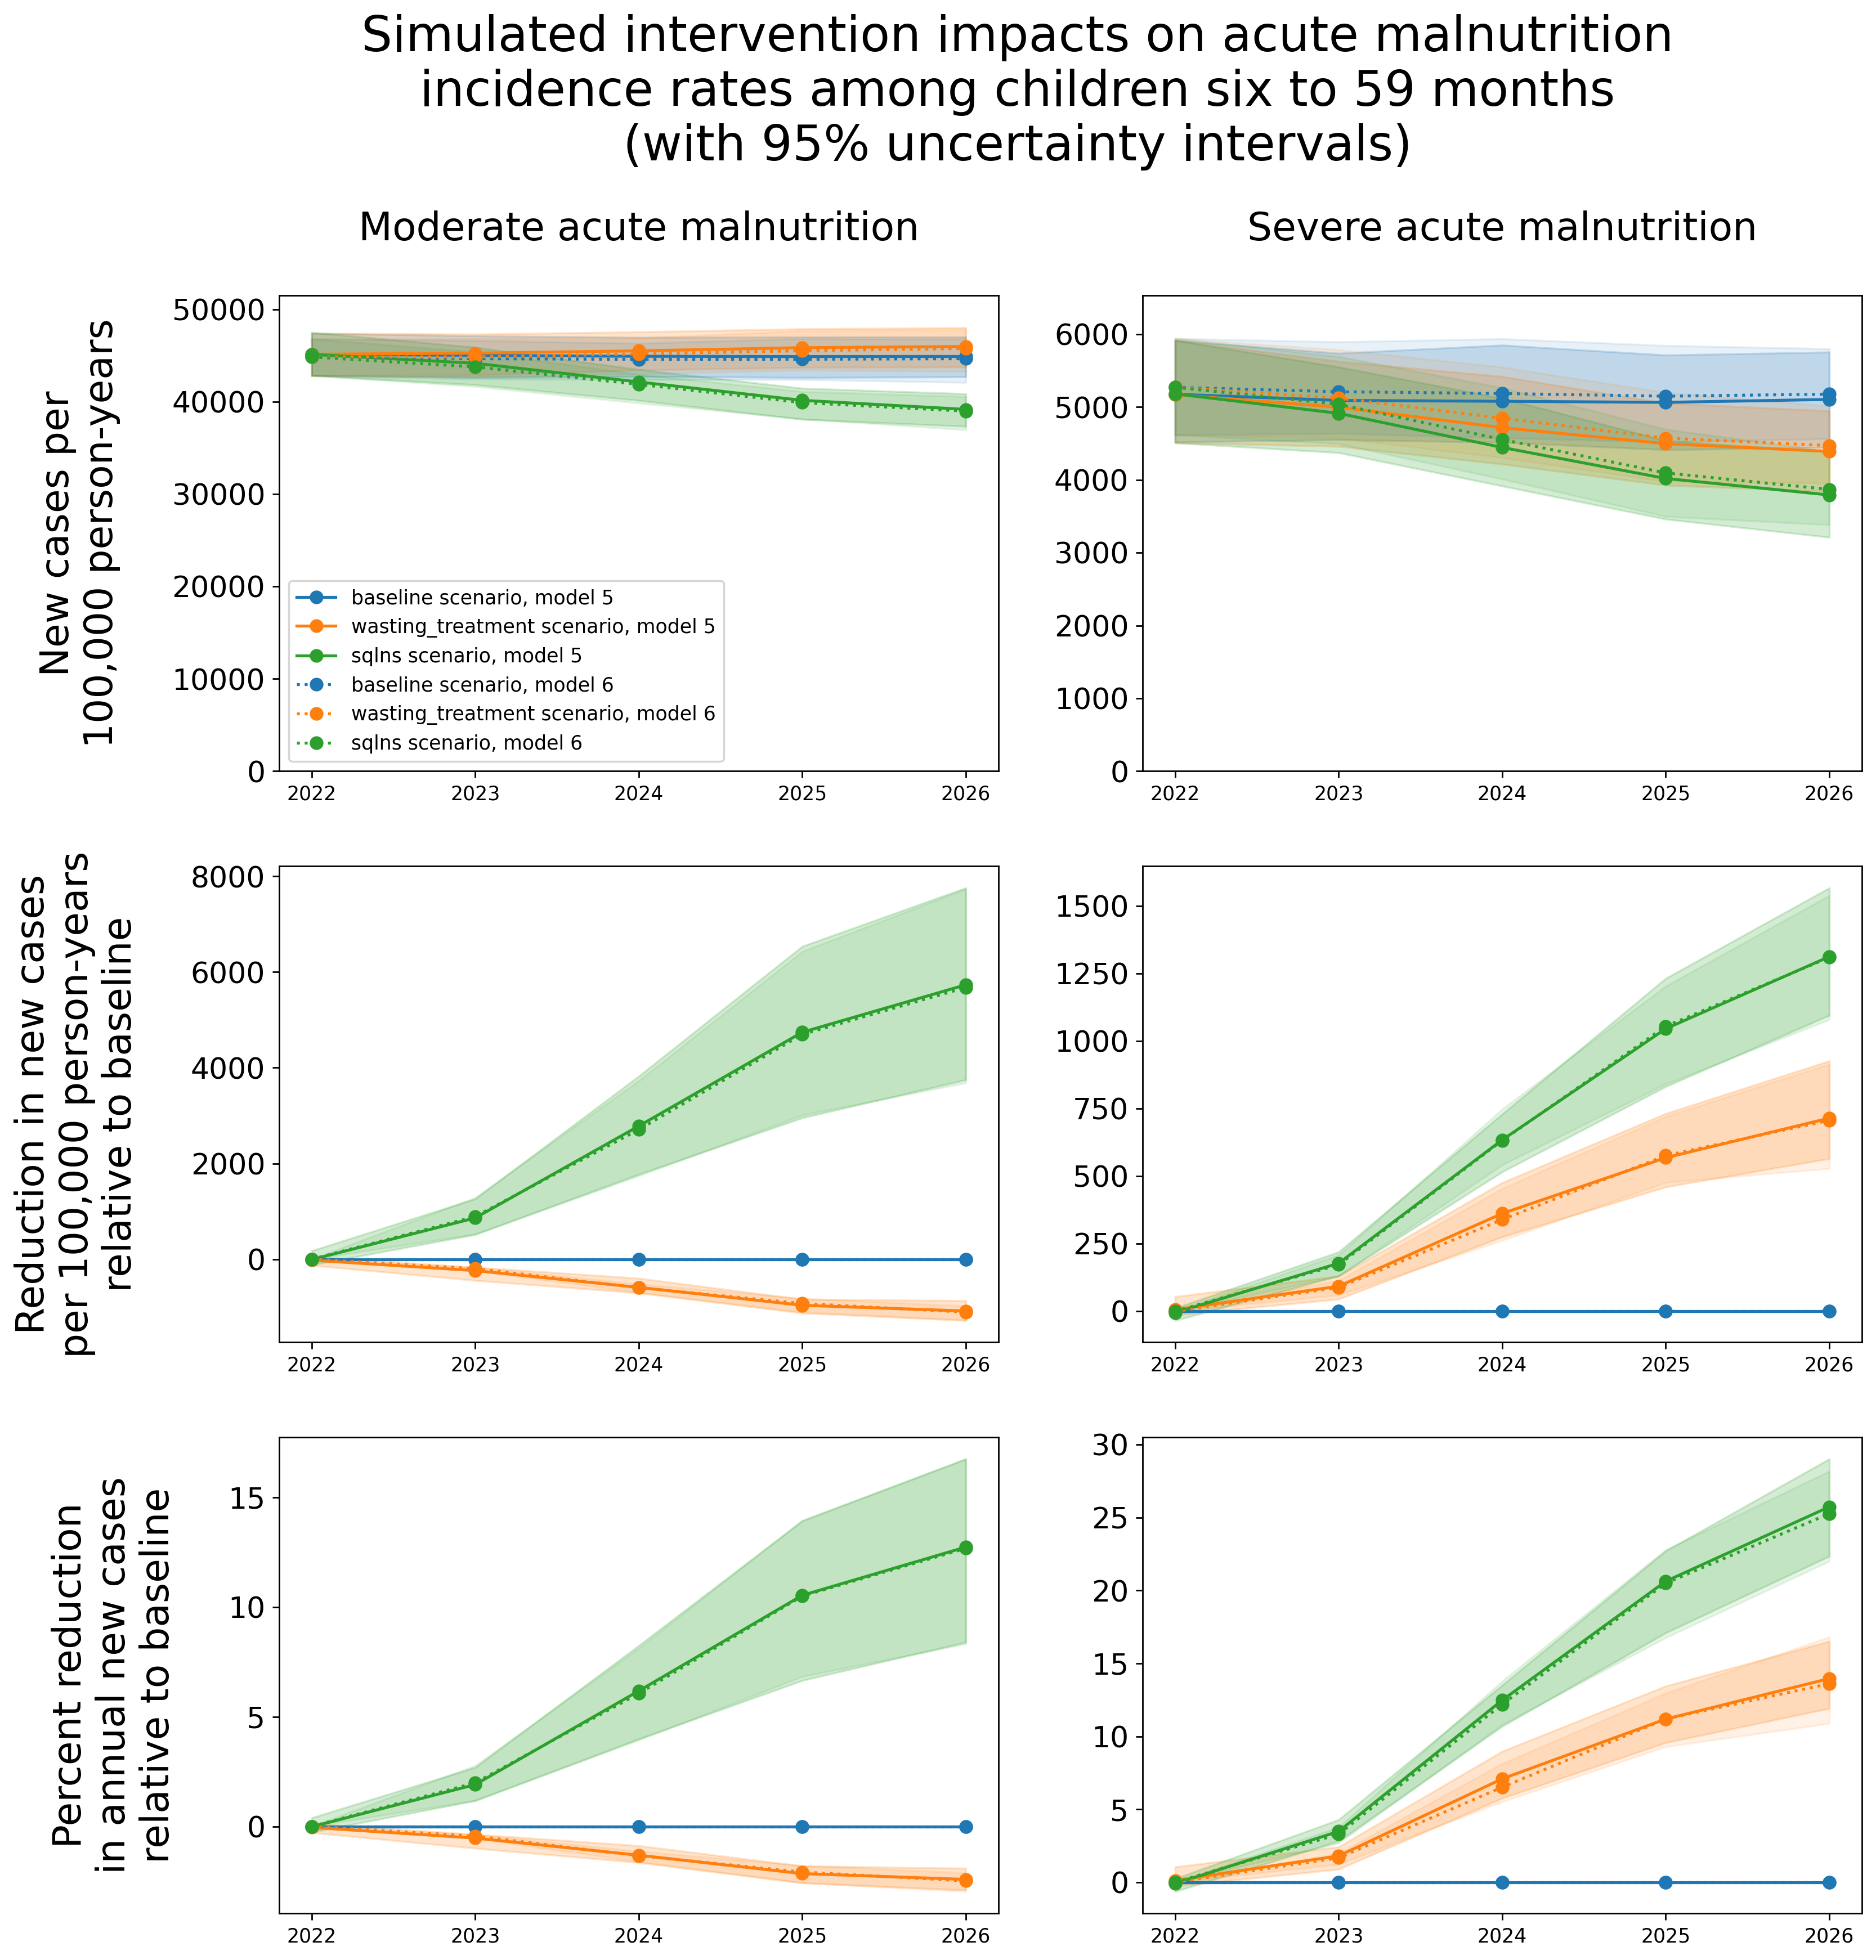

In [70]:
causes = ['mild_child_wasting_to_moderate_acute_malnutrition_event_count',
          'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count',
          #'total_mam',
          #'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count'
         ]

cause_titles = ['Moderate acute malnutrition\n',
                'Severe acute malnutrition\n',
                #'All transitions\ninto MAM\n',
                #'MAM cases from\nspontaneous\nSAM recovery'
               ]
metrics = ['value','absolute_reduction','percent_reduction']
metric_titles=['New cases per\n100,000 person-years\n',
              'Reduction in new cases\nper 100,000 person-years\nrelative to baseline\n',
              'Percent reduction\nin annual new cases\nrelative to baseline\n']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year'], 
                                        'incidence', 
                                        metric, 
                                  'baseline')
    for model in ['5','6']:

        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.model==model)]
            pos = axs[metrics.index(metric),causes.index(cause)]   
            for i in ['baseline','wasting_treatment','sqlns']:
                p_sub = p.loc[p.scenario==i]
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if model == '5':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, model {model}',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            pos.set_xticklabels(p_sub.year.unique())#,Fontsize=15)
            pos.tick_params(axis='y', labelsize=15)
            if causes.index(cause)==0:
                pos.set_ylabel(metric_titles[metrics.index(metric)],size=20)
                if metrics.index(metric)==0:
                    pos.legend(#['Baseline','Alternative scenario 1','Alternative scenario 2'],
                          #bbox_to_anchor=[0.25,4.15], 
                          # fontsize=15
                    )
            if metrics.index(metric)==0:
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
            
plt.subplots_adjust(right=len(causes), top=len(metrics))
#plt.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute malnutrition\nincidence rates among children six to 59 months\n(with 95% uncertainty intervals)',
             y=len(metrics)+.5,x=1,size=25)

# Finding 3: relative to alternative scenario 1

Text(1.5, 2.75, 'Simulated intervention impacts on acute\nmalnutrition cross-sectional exposure among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)')

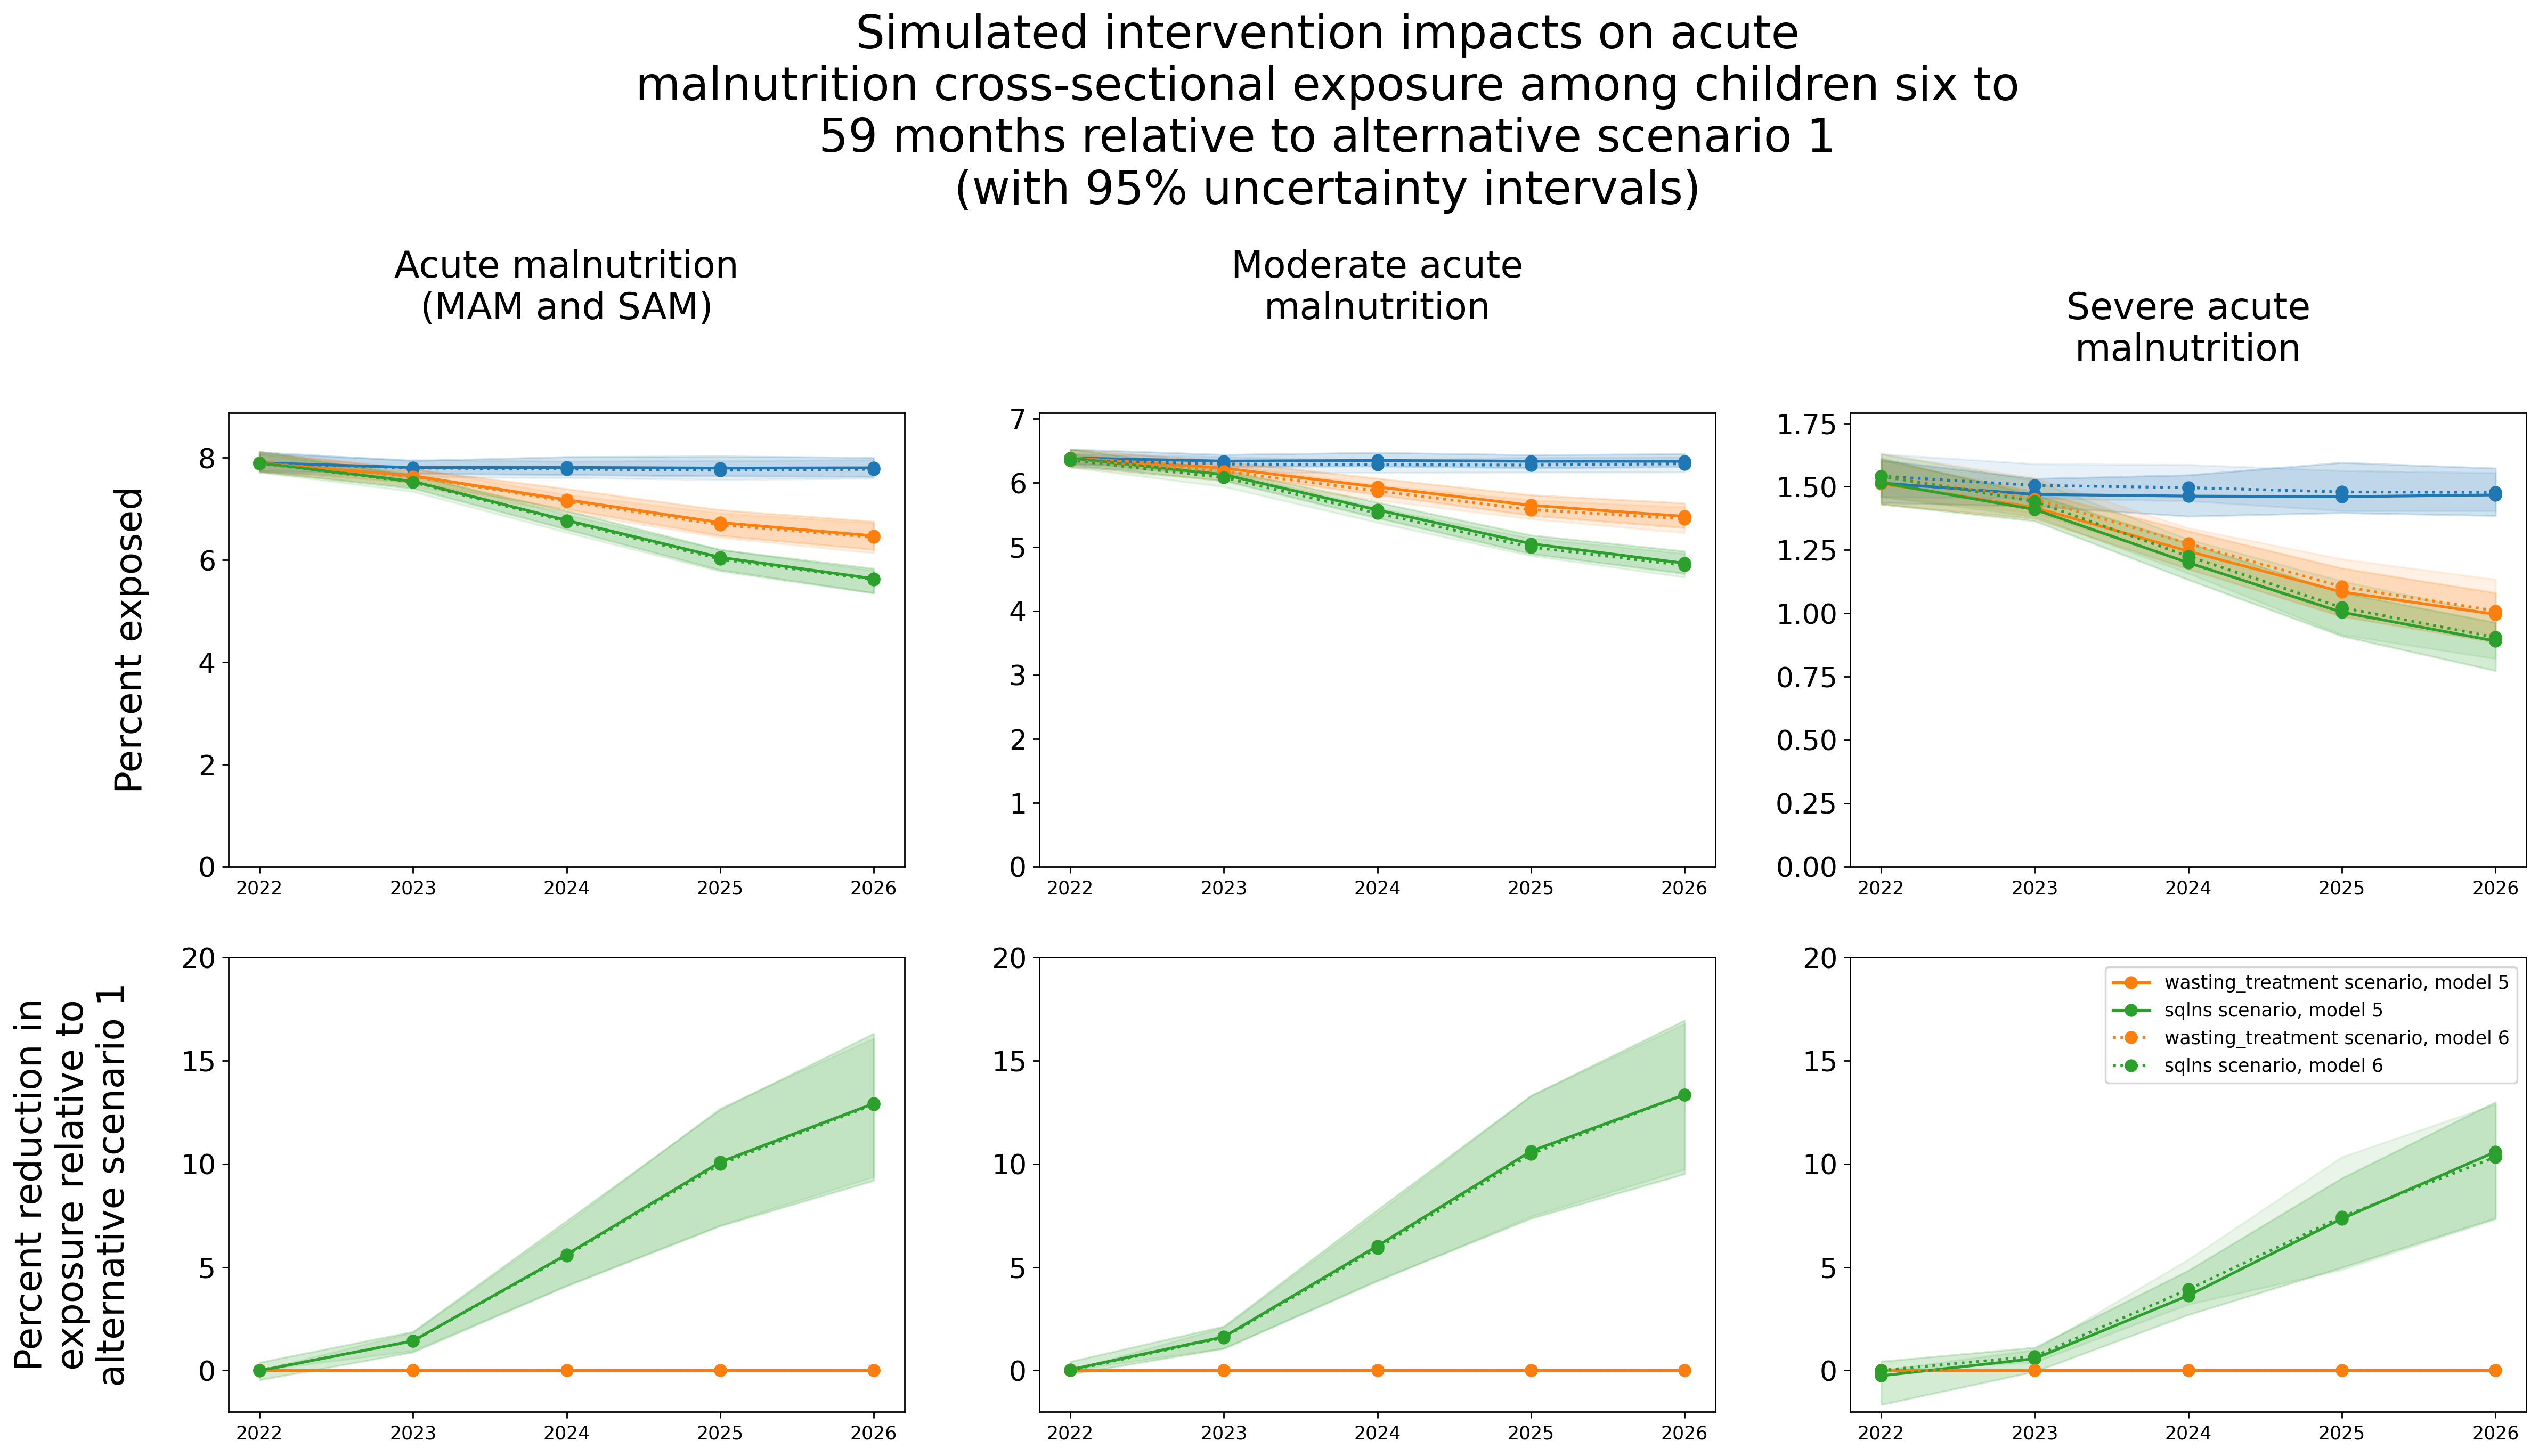

In [71]:
causes = ['wasted','moderate_acute_malnutrition','severe_acute_malnutrition']
cause_titles = ['Acute malnutrition\n(MAM and SAM)\n\n',
               'Moderate acute\nmalnutrition\n\n',
               'Severe acute\nmalnutrition\n']
metrics = ['value','percent_reduction']

fig, axs = plt.subplots(len(metrics), len(causes),dpi=250)
for metric in metrics:
    data = calculate_wasting_values(output_dir, six_to_59_ages, ['model','year'], 
                                        'prevalence', 
                                        metric, 
                                        'wasting_treatment')
    for model in ['5','6']:
        for cause in causes:
            p = data.loc[(data.cause==cause)&(data.model==model)]
            pos = axs[metrics.index(metric),causes.index(cause)]  
            if metric=='value':
                scenarios = ['baseline','wasting_treatment','sqlns']
            else:
                scenarios = ['wasting_treatment','sqlns']
            for i in scenarios:
                p_sub = p.loc[p.scenario==i]
                
                if i =='baseline':
                    color = 'tab:blue'
                elif i == 'wasting_treatment':
                    color='tab:orange'
                else:
                    color='tab:green'
                if model == '5':
                    linestyle='solid'
                    alpha=0.2
                else:
                    linestyle='dotted'
                    alpha=0.1
                pos.plot(p_sub['year'], p_sub['value','mean'], marker='o', label=f'{i} scenario, model {model}',
                        c = color, linestyle=linestyle)
                pos.fill_between(p_sub['year'], p_sub['value','2.5%'], p_sub['value','97.5%'], alpha=alpha, color=color)
            pos.grid()
            pos.set_xticks(p_sub.year.unique())
            pos.set_xticklabels(p_sub.year.unique())
            pos.tick_params(axis='y', labelsize=15)
            if metric=='value':
                pos.set_ylim(0,p.loc[p.scenario=='baseline']['value','97.5%'].max()*1.1)
                pos.set_title(cause_titles[causes.index(cause)],size=20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent exposed\n',size=20)
                    #pos.legend(['Baseline','Alternative scenario 1','Alternative scenario 2'], 
                    #       fontsize=15)
            if metric=='percent_reduction':
                pos.set_ylim(-2,20)
                if causes.index(cause)==0:
                    pos.set_ylabel('Percent reduction in\nexposure relative to\nalternative scenario 1\n',size=20)

plt.subplots_adjust(right=len(causes), top=len(metrics))
plt.legend()#bbox_to_anchor=[0.25,4.15], fontsize=20)
plt.suptitle('Simulated intervention impacts on acute\nmalnutrition cross-sectional exposure among children six to\n59 months relative to alternative scenario 1\n(with 95% uncertainty intervals)',
             y=2.75,x=1.5,size=25)